## Training Data

Designing a training data set for the MLP.

Importing libraries and redefining the noise and convolution functions from the RL workbook

In [1]:
import numpy as np
import pandas as pd
from numpy import random
import matplotlib.pyplot as plt
import torch

In [2]:
def gaussian_kernel_1D(size=21, sigma=2.0):
    ax = torch.linspace(-(size // 2), size // 2, size)
    kernel = torch.exp(-0.5 * (ax / sigma) ** 2)
    kernel = kernel / kernel.sum()
    return kernel

def poisson_noise(y, scale_factor=1000):
    photon_counts = y * scale_factor
    noisy_photons = torch.poisson(photon_counts)
    noisy_y = noisy_photons / scale_factor
    return torch.clamp(noisy_y, 0, 1)

def convo1d(image, kernel):

    if image.dim() == 1:
        image = image.unsqueeze(0).unsqueeze(0)  
    elif image.dim() == 2:
        image = image.unsqueeze(0)  

    if kernel.dim() == 1:
        kernel = kernel.unsqueeze(0).unsqueeze(0)
    elif kernel.dim() == 2:
        kernel = kernel.unsqueeze(0)
    
    padding = (kernel.shape[-1] - 1) // 2
    result = torch.nn.functional.conv1d(image, kernel, padding=padding)
    
    return result.squeeze()


Creates 4 different types of functions (sin, step, normal, triangular) and adds blur and noise to every function. 

Every function is unique with randomly generated periods or widths. All are clamped to betweem 0 and 1. 

In [3]:
def create_training_data(data_len, data_size, num_points, scale_factor=1000, seed=42):
    
    rng = np.random.default_rng(seed)

    x = torch.linspace(0, data_len, data_size)
    x = x.float()

    clean_data = {}
    blur_data = {}


    def blur_and_noise(y):
        y = convo1d(y, gaussian_kernel_1D(size=21, sigma=2.0))
        y = poisson_noise(y, scale_factor)
        y = y.numpy()
        return y

    for i in range(num_points//4):
        y = 0.5*torch.sin(x*rng.uniform(0,2)) + 0.5
        y = y * (0.9 - 0.1) + 0.1
        clean_data[f'y_clean_{i}'] = y.numpy()
        blur_data[f'y_blur_{i}'] = blur_and_noise(y)

    for i in range(num_points//4):
        period = rng.uniform(0.5, 2.0)
        y = (torch.sign(torch.sin(2 * torch.pi * x / period)) + 1) / 2
        y = y * (0.9 - 0.1) + 0.1
        clean_data[f'y_clean_{i + num_points//4}'] =  y.numpy()
        blur_data[f'y_blur_{i + num_points//4}'] = blur_and_noise(y)

    for i in range(num_points//4):
        mean = rng.uniform(data_len * 0.2, data_len * 0.8)
        std = rng.uniform(1, 3)
        y = torch.exp(-0.5 * ((x - mean) / std) ** 2)
        y = y * (0.9 - 0.1) + 0.1
        clean_data[f'y_clean_{i + 2*num_points//4}'] =  y.numpy()
        blur_data[f'y_blur_{i + 2*num_points//4}'] = blur_and_noise(y)

    for i in range(num_points//4):
        period = rng.uniform(0.5, 2.0)
        y = ((x % period) / period)
        y = y * (0.9 - 0.1) + 0.1
        clean_data[f'y_clean_{i + 3*num_points//4}'] =  y.numpy()
        blur_data[f'y_blur_{i + 3*num_points//4}'] = blur_and_noise(y)

    x_df = pd.DataFrame({'x': x.numpy()})
    clean_df = pd.DataFrame(clean_data)
    blur_df = pd.DataFrame(blur_data)
    
    training_data = pd.concat([x_df, clean_df, blur_df], axis=1)

    return training_data




Call function and test:

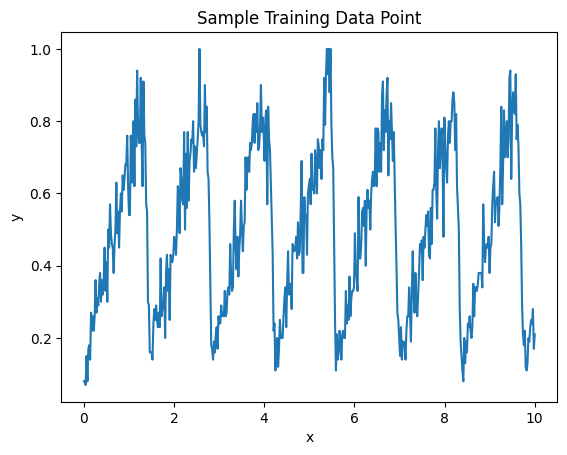

3293


,x,y_clean_0,y_clean_1,y_clean_2,y_clean_3,y_clean_4,y_clean_5,y_clean_6,y_clean_7,y_clean_8,...,y_blur_3990,y_blur_3991,y_blur_3992,y_blur_3993,y_blur_3994,y_blur_3995,y_blur_3996,y_blur_3997,y_blur_3998,y_blur_3999
0,0.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,...,0.07,0.04,0.06,0.05,0.11,0.15,0.02,0.05,0.06,0.03
1,0.020040,0.512406,0.507036,0.513762,0.511179,0.501510,0.515637,0.512201,0.512600,0.502054,...,0.14,0.13,0.10,0.13,0.10,0.08,0.08,0.04,0.12,0.05
2,0.040080,0.524800,0.514069,0.527508,0.522349,0.503020,0.531251,0.524390,0.525188,0.504108,...,0.21,0.07,0.13,0.14,0.06,0.13,0.19,0.08,0.11,0.07
3,0.060120,0.537171,0.521099,0.541222,0.533501,0.504529,0.546816,0.536557,0.537750,0.506162,...,0.23,0.09,0.09,0.16,0.19,0.14,0.20,0.13,0.11,0.17
4,0.080160,0.549505,0.528121,0.554887,0.544628,0.506039,0.562310,0.548690,0.550276,0.508215,...,0.35,0.12,0.20,0.12,0.09,0.11,0.14,0.14,0.18,0.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,9.919840,0.638257,0.763022,0.111892,0.881944,0.882411,0.694041,0.728226,0.544984,0.725811,...,0.41,0.38,0.53,0.53,0.28,0.57,0.23,0.18,0.60,0.74
496,9.939879,0.626549,0.757681,0.108791,0.885115,0.881966,0.707566,0.718101,0.532442,0.724112,...,0.55,0.58,0.36,0.51,0.19,0.69,0.27,0.30,0.62,0.54
497,9.959920,0.614719,0.752260,0.106153,0.887986,0.881515,0.720775,0.707772,0.519867,0.722408,...,0.44,0.46,0.32,0.55,0.19,0.78,0.34,0.22,0.50,0.39
498,9.979959,0.602779,0.746761,0.103982,0.890554,0.881058,0.733645,0.697250,0.507273,0.720698,...,0.42,0.33,0.31,0.43,0.14,0.80,0.21,0.23,0.59,0.29


In [9]:

num_points = 4000

rng = np.random.default_rng()
pick = rng.integers(0, num_points)


training_data = create_training_data(data_len=10, data_size=500, num_points=num_points, scale_factor=100, seed=42)

# #training_data.plot(x='x', y='y_1', kind='scatter')
plt.plot(training_data['x'], training_data[f'y_blur_{pick}'])
plt.title('Sample Training Data Point')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

print(pick)

training_data

#training_data.info()




Save the data as a pickle file for better functionality due to large size.

In [5]:
def save_training_data(training_data, filename="C:\\Users\\Jpjha\\OneDrive\\Desktop\\Decon by ML\\Code\\training_data.pkl"):
    training_data.to_pickle(filename)
    print(f'Training data saved to {filename}')

save_training_data(training_data)

Training data saved to C:\Users\Jpjha\OneDrive\Desktop\Decon by ML\Code\training_data.pkl


In [6]:
validation_data = create_training_data(data_len=10, data_size=500, num_points=8, scale_factor=1000, seed=24)
save_training_data(validation_data, filename="C:\\Users\\Jpjha\\OneDrive\\Desktop\\Decon by ML\\Code\\validation_data.pkl")


Training data saved to C:\Users\Jpjha\OneDrive\Desktop\Decon by ML\Code\validation_data.pkl


In [7]:
validation_data

,x,y_clean_0,y_clean_1,y_clean_2,y_clean_3,y_clean_4,y_clean_5,y_clean_6,y_clean_7,y_blur_0,y_blur_1,y_blur_2,y_blur_3,y_blur_4,y_blur_5,y_blur_6,y_blur_7
0,0.000000,0.500000,0.500000,0.5,0.5,0.133664,0.100000,0.100000,0.100000,0.255,0.281,0.465,0.476,0.071,0.047,0.070,0.060
1,0.020040,0.505295,0.506496,0.9,0.9,0.134465,0.100000,0.109935,0.109264,0.386,0.378,0.617,0.605,0.100,0.077,0.079,0.101
2,0.040080,0.510589,0.512989,0.9,0.9,0.135283,0.100000,0.119870,0.118528,0.478,0.474,0.762,0.733,0.119,0.112,0.114,0.101
3,0.060120,0.515881,0.519480,0.9,0.9,0.136117,0.100000,0.129805,0.127792,0.493,0.529,0.811,0.833,0.136,0.090,0.133,0.107
4,0.080160,0.521170,0.525965,0.9,0.9,0.136967,0.100000,0.139740,0.137057,0.526,0.572,0.876,0.943,0.116,0.100,0.152,0.155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,9.919840,0.606401,0.893203,0.9,0.1,0.184632,0.159349,0.217772,0.685749,0.620,0.875,0.835,0.083,0.194,0.152,0.206,0.676
496,9.939879,0.611495,0.891959,0.9,0.1,0.182965,0.157072,0.227706,0.695013,0.612,0.841,0.867,0.109,0.178,0.135,0.235,0.608
497,9.959920,0.616570,0.890612,0.9,0.1,0.181323,0.154867,0.237642,0.704277,0.554,0.813,0.787,0.086,0.188,0.141,0.210,0.598
498,9.979959,0.621625,0.889161,0.9,0.1,0.179707,0.152731,0.247576,0.713541,0.470,0.681,0.695,0.074,0.131,0.114,0.189,0.563


In [11]:
CNN_test_data = create_training_data(data_len=10, data_size=500, num_points=4, scale_factor=1000, seed=99)
save_training_data(CNN_test_data, filename="C:\\Users\\Jpjha\\OneDrive\\Desktop\\Decon by ML\\Code\\CNN_test_data.pkl")

Training data saved to C:\Users\Jpjha\OneDrive\Desktop\Decon by ML\Code\CNN_test_data.pkl
